Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.
Classes: ['cats', 'dogs']
Extracting train features ...
Train features shape: (8005, 2048)
Extracting test features ...
Test features shape: (2023, 2048)

Training Logistic Regression ...
Logistic Regression accuracy: 0.9915966386554622
              precision    recall  f1-score   support

        cats       0.99      0.99      0.99      1011
        dogs       0.99      0.99      0.99      1012

    accuracy                           0.99      2023
   macro avg       0.99      0.99      0.99      2023
weighted avg       0.99      0.99      0.99      2023


Training SVM ...
SVM accuracy: 0.9891250617894216
              precision    recall  f1-score   support

        cats       0.99      0.99      0.99      1011
        dogs       0.99      0.99      0.99      1012

    accuracy                           0.99      2023
   macro avg       0.99      0.99      0.99      2023
weighted avg       0.99      0.

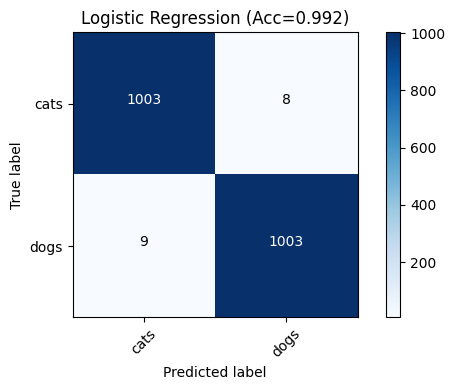

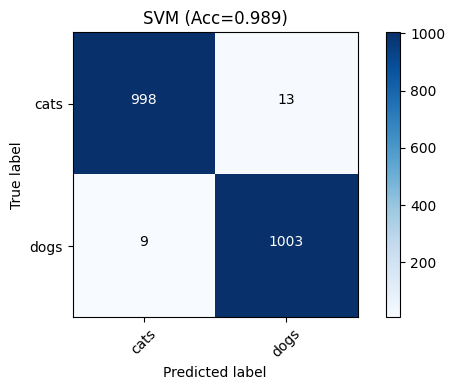

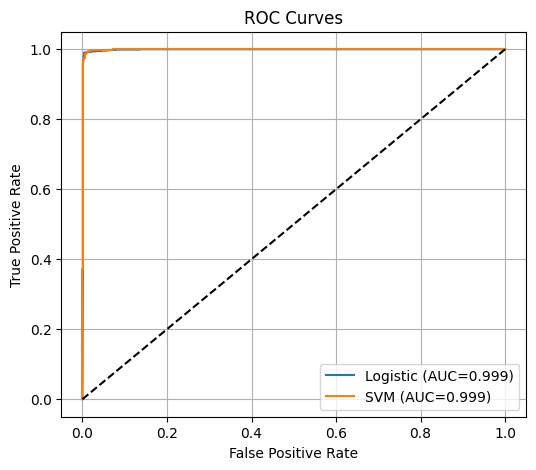

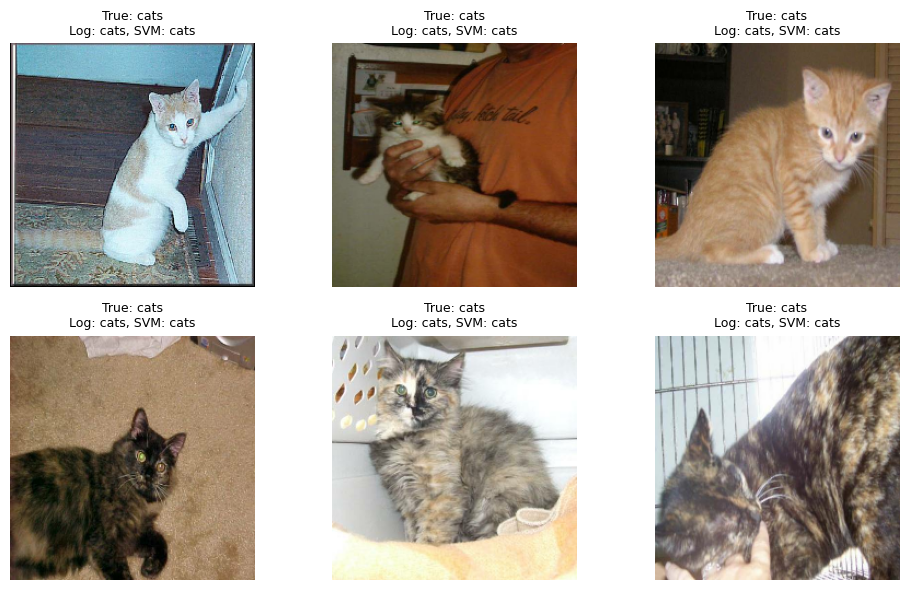


Logistic Regression Confusion Matrix:
 [[1003    8]
 [   9 1003]]

SVM Confusion Matrix:
 [[ 998   13]
 [   9 1003]]


In [35]:
# Binary Image Classification using Logistic Regression (Sigmoid) and SVM
# Dataset: Cats vs Dogs
# Environment: Kaggle (GPU)

import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import random

# -------------------------------
# 1. Dataset Paths
# -------------------------------
train_dir = "/kaggle/input/cat-and-dog/training_set/training_set"
test_dir  = "/kaggle/input/cat-and-dog/test_set/test_set"

# -------------------------------
# 2. Create Datasets
# -------------------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
seed = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

# -------------------------------
# 3. Feature Extraction (ResNet50)
# -------------------------------
feature_extractor = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))

def extract_features_from_dataset(dataset, model):
    features, labels = [], []
    for batch_images, batch_labels in dataset:
        x = tf.keras.applications.resnet.preprocess_input(batch_images.numpy().astype('float32'))
        feats = model.predict(x, verbose=0)
        features.append(feats)
        labels.append(batch_labels.numpy())
    return np.vstack(features), np.concatenate(labels)

print("Extracting train features ...")
X_train, y_train = extract_features_from_dataset(train_ds, feature_extractor)
print("Train features shape:", X_train.shape)

print("Extracting test features ...")
X_test, y_test = extract_features_from_dataset(test_ds, feature_extractor)
print("Test features shape:", X_test.shape)

# -------------------------------
# 4. Feature Scaling
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# -------------------------------
# 5A. Logistic Regression (Sigmoid)
# -------------------------------
print("\nTraining Logistic Regression ...")
log_clf = LogisticRegression(
    solver='saga',
    penalty='l2',
    max_iter=2000,
    C=1.0,
    random_state=seed,
    n_jobs=-1
)
log_clf.fit(X_train_scaled, y_train)
y_pred_log = log_clf.predict(X_test_scaled)
y_prob_log = log_clf.predict_proba(X_test_scaled)[:,1]

acc_log = accuracy_score(y_test, y_pred_log)
print("Logistic Regression accuracy:", acc_log)
print(classification_report(y_test, y_pred_log, target_names=class_names))

# -------------------------------
# 5B. Support Vector Machine (SVM)
# -------------------------------
print("\nTraining SVM ...")
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=seed)
svm_clf.fit(X_train_scaled, y_train)
y_pred_svm = svm_clf.predict(X_test_scaled)
y_prob_svm = svm_clf.predict_proba(X_test_scaled)[:,1]

acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM accuracy:", acc_svm)
print(classification_report(y_test, y_pred_svm, target_names=class_names))

# -------------------------------
# 6. Confusion Matrices
# -------------------------------
def plot_confusion_matrix(cm, classes, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6,4))
plot_confusion_matrix(cm_log, class_names, title=f'Logistic Regression (Acc={acc_log:.3f})')
plt.show()

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,4))
plot_confusion_matrix(cm_svm, class_names, title=f'SVM (Acc={acc_svm:.3f})')
plt.show()

# -------------------------------
# 7. ROC Curves
# -------------------------------
y_test_bin = label_binarize(y_test, classes=[0,1]).ravel()
fpr_log, tpr_log, _ = roc_curve(y_test_bin, y_prob_log)
fpr_svm, tpr_svm, _ = roc_curve(y_test_bin, y_prob_svm)
roc_auc_log = auc(fpr_log, tpr_log)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(6,5))
plt.plot(fpr_log, tpr_log, label=f'Logistic (AUC={roc_auc_log:.3f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC={roc_auc_svm:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# -------------------------------
# 8. Show Sample Predictions (Fixed Visualization)
# -------------------------------
plt.figure(figsize=(10, 6))
for images, labels in test_ds.take(1):  # take 1 batch
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        label_true = class_names[labels[i]]
        
        # Preprocess and extract features for single image
        x = tf.keras.applications.resnet.preprocess_input(np.expand_dims(img, axis=0).astype('float32'))
        feat = feature_extractor.predict(x, verbose=0)
        feat_scaled = scaler.transform(feat)
        
        # Predictions from both models
        pred_log = log_clf.predict(feat_scaled)[0]
        pred_svm = svm_clf.predict(feat_scaled)[0]
        
        title = f"True: {label_true}\nLog: {class_names[pred_log]}, SVM: {class_names[pred_svm]}"
        plt.imshow(img)
        plt.title(title, fontsize=9)
        plt.axis("off")
plt.tight_layout()
plt.show()

# -------------------------------
# 9. Numeric Confusion Matrices
# -------------------------------
print("\nLogistic Regression Confusion Matrix:\n", cm_log)
print("\nSVM Confusion Matrix:\n", cm_svm)
